In [14]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import importlib

# Set plot style
sns.set_style('darkgrid')

from src.stock_path_simulator import StockPathSimulator

## Perpetual American Put Options

The simplest theoretical case of an American Put Option is a perpetual one where the expiration date is set to infinity. One can assume that, because time is set to infinite, the strategy of whether to exercise or not depends only on the price of the stock, not on time. The price of the perpetual American put is defined as:

$$
v(x) = \max_{\tau\in T} \tilde{E}[e^{-r\tau}(K-S(\tau))]
$$

where $K$ is the strike price, $S(\tau)$ is the price of the underlying asset at time $\tau$, $T$ is the set of all stopping times, and the exponential term tracks the growth of money under fixed interest rate $r$. 

Assume that the stock asset is priced as a geometric Brownian motion:

$$
S(t) = S(0) \exp\left\{\sigma \tilde{W}(t) + \left(r-\frac{1}{2}\sigma^2\right) t\right\}
$$

with a Wiener process $\tilde{W}(t)$. If the owner uses a strategy to exercise the option as soon as it falls below a value $L$, exercising at $\tau_L = \min(t\geq 0;S(t)=L)$, then the value function is:

$$
v_L(x)=\begin{cases}
K - x, & 0 \le x \le L,\\[6pt]
(K-L)\left(\dfrac{x}{L}\right)^{-\frac{2r}{\sigma^{2}}}, & x \ge L .
\end{cases}
$$

where the first case corresponds to exercising at $t=0$ (the stock value is below $L$), and the second case is the expected value when waiting for the stock price to drop below $L$. Following Steve Shreve 8.3, this function $v_L(x)$ has a well-defined optimum at:

$$L_* = \frac{2r}{2r+\sigma^2}K$$

# Monte Carlo Analysis of Perpetual American Put Options

Let's perform a Monte Carlo simulation to analyze the perpetual American put option and find the optimal exercise boundary.

In [36]:
# Model parameters
S0 = 140       # Initial stock price
K = 140        # Strike price
sigma = 0.3    # Volatility
r = 0.035      # Risk-free rate
T = 1000         # Time horizon (years)
mu = 0         # Drift (risk-neutral)
# Simulation parameters
simulation_amounts = 1000
n_steps = 200000

# Create StockPathSimulator instance with explicit parameters
sps = StockPathSimulator(
    S0=S0,
    sigma=sigma,
    T=T,
    r=r,
    mu=mu,
    n_sims=simulation_amounts,
    n_steps=n_steps
)

# Alternative: you can also use keyword arguments selectively
# sps = StockPathSimulator(S0=S0, sigma=sigma, r=r, n_sims=simulation_amounts)

print(f"Created simulator with S0={sps.S0}, sigma={sps.sigma}, r={sps.r}")

Created simulator with S0=140, sigma=0.3, r=0.035


In [37]:
def return_for_perpetual_american_put_simulation(L):
    """
    Simulate stock paths and calculate the return for a perpetual American put option.
    For perpetual options, we need to generate fresh paths for each L to avoid bias.
    """
    # Generate fresh paths for each L value
    paths = sps.stock_paths
    
    payoffs = []
    exercise_times = []

        # For each path, use the strategy with L to determine its payoff
    for i in range(sps.n_sims):
        path = paths[i]
        exercised = False
        
        # Check if we should exercise immediately (at t=0)
        if path[0] <= L:
            # Exercise immediately at t=0, no discounting needed
            payoff = sps.put_option_payoff(path[0], K, 0)  # t=0 for immediate exercise
            payoffs.append(payoff)
            exercise_times.append(0)
            exercised = True
        else:
            # Look for first hitting time when stock goes at or below boundary L
            for j in range(1, len(path)):
                if path[j] <= L:
                    # Exercise option at first time stock hits or goes below boundary
                    exercise_time = T * (j / n_steps)  # Actual time when exercised
                    payoff = sps.put_option_payoff(path[j], K, exercise_time)
                    payoffs.append(payoff)
                    exercise_times.append(j)
                    exercised = True
                    break
        
        if not exercised:
            # For perpetual options, if boundary never hit, option has no value
            # (This shouldn't happen often with reasonable L values)
            payoffs.append(0)
            exercise_times.append(n_steps)

    average_payoff = np.mean(payoffs)
    std_payoff = np.std(payoffs)/np.sqrt(len(payoffs))
    
    # Calculate proportion that exercised
    exercised_count = sum(1 for t in exercise_times if t < n_steps)
    
    # Only print summary, not individual paths (too verbose)
    print(f"L={L:.1f}: Avg Payoff={average_payoff:.4f}, Std={std_payoff:.4f}, Exercises: {exercised_count}/{len(exercise_times)} ({100*exercised_count/len(exercise_times):.1f}%)")

    return average_payoff, std_payoff, payoffs, exercise_times

Model parameters:
S0 = 140, K = 140, sigma = 0.3, r = 0.035
Alpha parameter: 0.4375
Theoretical optimal exercise boundary: L* = 61.25

Running simulations...
L=42.0: Avg Payoff=39.0868, Std=0.9723, Exercises: 984/1000 (98.4%)
L=42.0: Avg Payoff=39.0868, Std=0.9723, Exercises: 984/1000 (98.4%)
L=47.0: Avg Payoff=40.5165, Std=0.9438, Exercises: 984/1000 (98.4%)
L=47.0: Avg Payoff=40.5165, Std=0.9438, Exercises: 984/1000 (98.4%)
L=52.0: Avg Payoff=41.4358, Std=0.9133, Exercises: 985/1000 (98.5%)
L=52.0: Avg Payoff=41.4358, Std=0.9133, Exercises: 985/1000 (98.5%)
L=57.0: Avg Payoff=41.6094, Std=0.8741, Exercises: 986/1000 (98.6%)
L=57.0: Avg Payoff=41.6094, Std=0.8741, Exercises: 986/1000 (98.6%)
L=62.0: Avg Payoff=41.7857, Std=0.8302, Exercises: 987/1000 (98.7%)
L=62.0: Avg Payoff=41.7857, Std=0.8302, Exercises: 987/1000 (98.7%)
L=67.0: Avg Payoff=41.2748, Std=0.7838, Exercises: 988/1000 (98.8%)
L=67.0: Avg Payoff=41.2748, Std=0.7838, Exercises: 988/1000 (98.8%)
L=72.0: Avg Payoff=40.5312

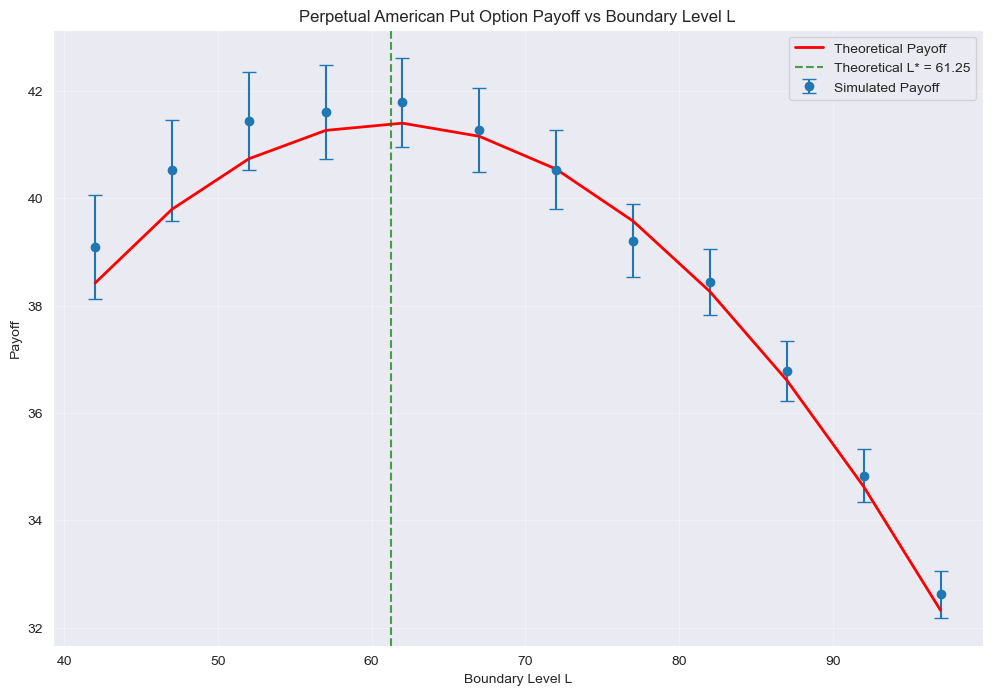


Optimal boundary analysis:
Simulated optimal L: 62.0
Theoretical optimal L: 61.25
Maximum simulated payoff: 41.7857
Theoretical payoff at optimal L: 41.4010

There exists error because of finite T in the simulation


In [38]:
# First, let's calculate the theoretical optimal boundary
alpha = (2 * r) / (2 * r + sigma**2)
theoretical_optimal_L = K * alpha

print(f"Model parameters:")
print(f"S0 = {S0}, K = {K}, sigma = {sigma}, r = {r}")
print(f"Alpha parameter: {alpha:.4f}")
print(f"Theoretical optimal exercise boundary: L* = {theoretical_optimal_L:.2f}")
print()

# Test L values around the theoretical optimum, but also include the range used before
L_values = np.arange(0.3*K, 0.7*K, 5)  # More focused range around reasonable values
results = []

print("Running simulations...")
for L in L_values:
    avg_payoff, std_payoff, payoffs, exercise_times = return_for_perpetual_american_put_simulation(L)
    results.append((L, avg_payoff, std_payoff))

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['L', 'Average Payoff', 'Std Dev'])
print("\nResults Summary:")
print(results_df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.errorbar(results_df['L'], results_df['Average Payoff'], yerr=results_df['Std Dev'], 
             fmt='o', label='Simulated Payoff', capsize=5, markersize=6)

# Theoretical value calculation - this is the value when starting at S0=140
theoretical_values = []
for L in L_values:
    if S0 <= L:
        # If current price is below boundary, exercise immediately
        theoretical_value = K - S0
    else:
        # If current price is above boundary, use the formula
        theoretical_value = (K - L) * (S0 / L) ** (-2 * r / sigma**2)
    theoretical_values.append(theoretical_value)

plt.plot(L_values, theoretical_values, label='Theoretical Payoff', color='red', linewidth=2)

# Mark the theoretical optimal boundary
plt.axvline(x=theoretical_optimal_L, color='green', linestyle='--', 
            label=f'Theoretical L* = {theoretical_optimal_L:.2f}', alpha=0.7)

plt.xlabel('Boundary Level L')
plt.ylabel('Payoff')
plt.title('Perpetual American Put Option Payoff vs Boundary Level L')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the optimal L from simulation
optimal_idx = np.argmax(results_df['Average Payoff'])
optimal_L_sim = results_df.iloc[optimal_idx]['L']
max_payoff_sim = results_df.iloc[optimal_idx]['Average Payoff']

print(f"\nOptimal boundary analysis:")
print(f"Simulated optimal L: {optimal_L_sim:.1f}")
print(f"Theoretical optimal L: {theoretical_optimal_L:.2f}")
print(f"Maximum simulated payoff: {max_payoff_sim:.4f}")
print(f"Theoretical payoff at optimal L: {(K - theoretical_optimal_L) * (S0 / theoretical_optimal_L) ** (-2 * r / sigma**2):.4f}")
print()

There are two sources of error in this simulation: one comes from averaging the different Monte-Carlo simulated paths, which is the error bar shown above, and the other from a finite timescale of the simulation with a finite number of timesteps, which is a systematic error that can't be easily estimated. 

# Perpetual american call option


See https://personal.ntu.edu.sg/nprivault/MA5182/american-options.pdf

The price of perpetual American option is given by (assuming $L > K$)

$$
v_L(x)=\begin{cases}
x - K, & x \ge L \ge K,\\[6pt]
(L-K)\left(\dfrac{x}{L}\right), & 0 < x \le L .
\end{cases}
$$

In [39]:
def return_for_perpetual_american_call_simulation(L):
    """
    Simulate stock paths and calculate the return for a perpetual American call option.
    For perpetual options, we need to generate fresh paths for each L to avoid bias.
    """
    # Generate fresh paths for each L value
    paths = sps.stock_paths
    
    payoffs = []
    exercise_times = []

        # For each path, use the strategy with L to determine its payoff
    for i in range(sps.n_sims):
        path = paths[i]
        exercised = False
        
        # Check if we should exercise immediately (at t=0)
        if path[0] >= L:
            # Exercise immediately at t=0, no discounting needed
            payoff = sps.call_option_payoff(path[0], K, 0)  # t=0 for immediate exercise
            payoffs.append(payoff)
            exercise_times.append(0)
            exercised = True
        else:
            # Look for first hitting time when stock goes at or above boundary L
            for j in range(1, len(path)):
                if path[j] >= L:
                    # Exercise option at first time stock hits or goes below boundary
                    exercise_time = T * (j / n_steps)  # Actual time when exercised
                    payoff = sps.call_option_payoff(path[j], K, exercise_time)
                    payoffs.append(payoff)
                    exercise_times.append(j)
                    exercised = True
                    break
        
        if not exercised:
            # For perpetual options, if boundary never hit, option has no value
            # (This shouldn't happen often with reasonable L values)
            payoffs.append(0)
            exercise_times.append(n_steps)

    average_payoff = np.mean(payoffs)
    std_payoff = np.std(payoffs)/np.sqrt(len(payoffs))
    
    # Calculate proportion that exercised
    exercised_count = sum(1 for t in exercise_times if t < n_steps)
    
    # Only print summary, not individual paths (too verbose)
    print(f"L={L:.1f}: Avg Payoff={average_payoff:.4f}, Std={std_payoff:.4f}, Exercises: {exercised_count}/{len(exercise_times)} ({100*exercised_count/len(exercise_times):.1f}%)")

    return average_payoff, std_payoff, payoffs, exercise_times

Model parameters for call option:
S0 = 140, K = 140, sigma = 0.3, r = 0.035

Running call option simulations...
Note: For non-dividend paying stocks, it's typically never optimal to exercise early

L=145.0: Avg Payoff=6.5681, Std=0.0606, Exercises: 986/1000 (98.6%)
L=155.0: Avg Payoff=15.1636, Std=0.1389, Exercises: 972/1000 (97.2%)
L=155.0: Avg Payoff=15.1636, Std=0.1389, Exercises: 972/1000 (97.2%)
L=165.0: Avg Payoff=22.7081, Std=0.2547, Exercises: 956/1000 (95.6%)
L=165.0: Avg Payoff=22.7081, Std=0.2547, Exercises: 956/1000 (95.6%)
L=175.0: Avg Payoff=29.4444, Std=0.3790, Exercises: 948/1000 (94.8%)
L=175.0: Avg Payoff=29.4444, Std=0.3790, Exercises: 948/1000 (94.8%)
L=185.0: Avg Payoff=35.7564, Std=0.5109, Exercises: 941/1000 (94.1%)
L=185.0: Avg Payoff=35.7564, Std=0.5109, Exercises: 941/1000 (94.1%)
L=195.0: Avg Payoff=40.9815, Std=0.6413, Exercises: 934/1000 (93.4%)
L=195.0: Avg Payoff=40.9815, Std=0.6413, Exercises: 934/1000 (93.4%)
L=205.0: Avg Payoff=46.4860, Std=0.7763, Exe

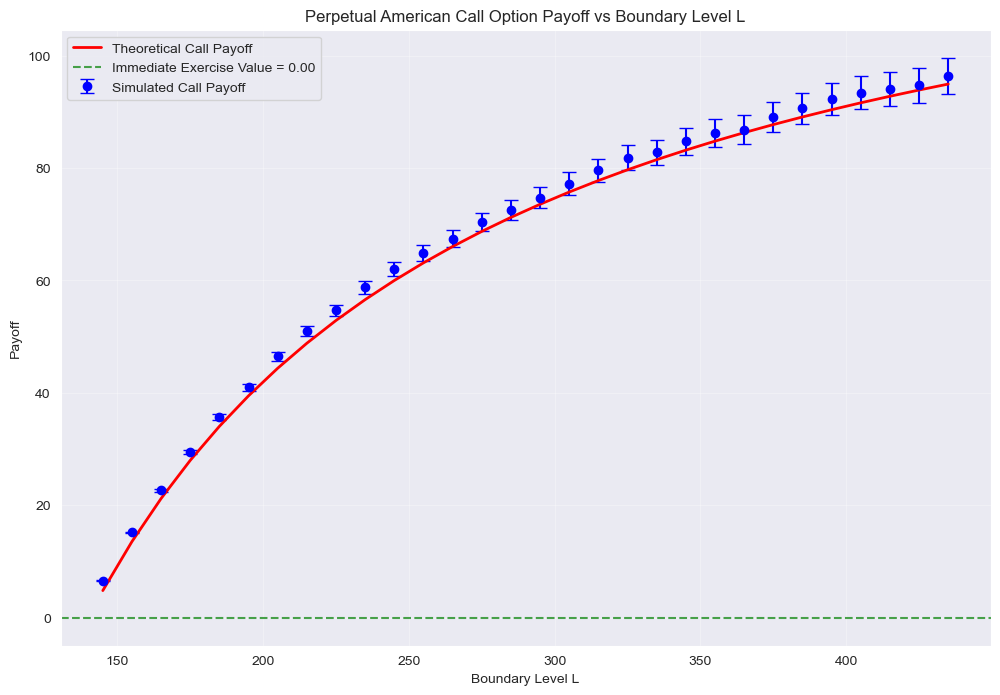


Call Option Analysis:
Simulated 'optimal' L: 435.0
Maximum simulated payoff: 96.4443
Immediate exercise value: 0.0000
European call option value (for comparison): 0.0000

Theory note: For non-dividend paying stocks, perpetual American calls
should never be exercised early, making the optimal boundary L = ∞
The declining payoff as L increases confirms this theoretical result.

There exists error because of finite T in the simulation


In [40]:
# For perpetual American call options, there is no optimal finite boundary
# because it's never optimal to exercise early for a non-dividend paying stock
# However, let's analyze different boundary levels for educational purposes

# Note: For call options, L should be > K for the theoretical formula to apply
# The optimal strategy for perpetual American calls on non-dividend stocks 
# is typically to never exercise early (L = infinity)

print(f"Model parameters for call option:")
print(f"S0 = {S0}, K = {K}, sigma = {sigma}, r = {r}")
print()

# Test L values above the strike price K
L_values_call = np.arange(K + 5, K + 300, 10)  # L values above K
results_call = []

print("Running call option simulations...")
print("Note: For non-dividend paying stocks, it's typically never optimal to exercise early")
print()

for L in L_values_call:
    avg_payoff, std_payoff, payoffs, exercise_times = return_for_perpetual_american_call_simulation(L)
    results_call.append((L, avg_payoff, std_payoff))

# Convert results to DataFrame for easier plotting
results_call_df = pd.DataFrame(results_call, columns=['L', 'Average Payoff', 'Std Dev'])
print("\nCall Option Results Summary:")
print(results_call_df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.errorbar(results_call_df['L'], results_call_df['Average Payoff'], yerr=results_call_df['Std Dev'], 
             fmt='o', label='Simulated Call Payoff', capsize=5, markersize=6, color='blue')

# Theoretical value calculation for call options
# For perpetual American calls: v_L(x) = (L-K)(x/L) when x <= L, and x-K when x >= L
theoretical_values_call = []
for L in L_values_call:
    if S0 >= L:
        # If current price is above boundary, exercise immediately
        theoretical_value = S0 - K
    else:
        # If current price is below boundary, use the formula: (L-K)(x/L)
        theoretical_value = (L - K) * (S0 / L)
    theoretical_values_call.append(theoretical_value)

plt.plot(L_values_call, theoretical_values_call, label='Theoretical Call Payoff', color='red', linewidth=2)

# For comparison, show the immediate exercise value (S0 - K)
immediate_exercise_value = max(S0 - K, 0)
plt.axhline(y=immediate_exercise_value, color='green', linestyle='--', 
            label=f'Immediate Exercise Value = {immediate_exercise_value:.2f}', alpha=0.7)

plt.xlabel('Boundary Level L')
plt.ylabel('Payoff')
plt.title('Perpetual American Call Option Payoff vs Boundary Level L')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the "optimal" L from simulation (though theory says it should be infinity)
optimal_idx_call = np.argmax(results_call_df['Average Payoff'])
optimal_L_sim_call = results_call_df.iloc[optimal_idx_call]['L']
max_payoff_sim_call = results_call_df.iloc[optimal_idx_call]['Average Payoff']

print(f"\nCall Option Analysis:")
print(f"Simulated 'optimal' L: {optimal_L_sim_call:.1f}")
print(f"Maximum simulated payoff: {max_payoff_sim_call:.4f}")
print(f"Immediate exercise value: {immediate_exercise_value:.4f}")
print(f"European call option value (for comparison): {max(S0 - K, 0):.4f}")
print()
print("Theory note: For non-dividend paying stocks, perpetual American calls")
print("should never be exercised early, making the optimal boundary L = ∞")
print("The declining payoff as L increases confirms this theoretical result.")
print()
print("There exists error because of finite T in the simulation")